In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.dates as mdates
import numpy as np
from scipy import *
import ipywidgets as widgets

In [63]:
# Sets plot style

sns.set_theme()

# Sets colour for each person
palette = {"Sal": "tab:cyan",
           "Joe": "tab:orange",
           "Oli": "tab:purple",
           "Tom": 'tab:pink',
           "George": 'tab:olive',
           "Harvey": "tab:red"}

# Default size of each plot
figsize = (20, 8)

# Default user for each plot
user = "Tom"

# Default value for rolling average window duration
window_days = 60

In [64]:
def time_delta_to_num(time_delta):
    """ Takes in time delta and converts it into a number for plotting"""

    # specify a date to use for the times

    zero_date = datetime.datetime(2022, 6, 20)

    zero_num = mdates.date2num(zero_date)

    # adds zero_data to timedelta to convert

    time_delta_plus_date = [zero_date + time_unit for time_unit in time_delta]

    # convert datetimes to numbers

    time_delta_as_num = [mins - zero_num for mins in mdates.date2num(time_delta_plus_date)]

    return time_delta_as_num


In [65]:
def y_axis_generator(max_y_value, unit):
    """Creates range for y axis from 0 to max_y_value then passes it to time_delta_to_num. Returns y axis values as
    plottable number"""

    y_axis_time_range = list(range(0, max_y_value, 1))

    y_axis_time_delta = pd.to_timedelta(y_axis_time_range, unit=unit)

    y_axis_time_num = time_delta_to_num(y_axis_time_delta)

    return y_axis_time_num

In [66]:
def spline_smooth(df):
    """Smooths lines via interpolation and splines. Purely cosmetic"""

    df_spline = df.copy()

    df_spline['date_as_num'] = mdates.date2num(df_spline['timestamp'])

    x_smooth = np.linspace(df_spline['date_as_num'].min(), df_spline['date_as_num'].max(), 50)

    bspline = interpolate.make_interp_spline(df_spline['date_as_num'], df_spline['time_delta_as_num'])

    y_smooth = bspline(x_smooth)

    return x_smooth, y_smooth

In [67]:
def savgol_smooth(df):
    """Smooths lines using a Savitzky–Golay filter"""

    df_savgol = df.copy()

    df_savgol['date_as_num'] = mdates.date2num(df_savgol['timestamp'])

    max_window = len(df_savgol)

    polynomial_order = 10

    x_smooth = signal.savgol_filter(df_savgol['date_as_num'], max_window, polynomial_order)

    y_smooth = signal.savgol_filter(df_savgol['time_delta_as_num'], max_window, polynomial_order)

    return x_smooth, y_smooth

In [68]:
def time_delta_to_num(time_delta):
    """ Takes in time delta and converts it into a number for plotting"""

    # specify a date to use for the times

    zero_date = datetime.datetime(2022, 6, 20)

    zero_num = mdates.date2num(zero_date)

    # adds zero_data to timedelta to convert

    time_delta_plus_date = [zero_date + time_unit for time_unit in time_delta]

    # convert datetimes to numbers

    time_delta_as_num = [mins - zero_num for mins in mdates.date2num(time_delta_plus_date)]

    return time_delta_as_num


In [69]:
df=pd.read_csv('data.csv')

In [70]:
""" Drops unneeded columns and sets timestamp datatype. Creates submission time from timestamp and converts both
 submission time and completion time to time deltas represented as plottable numbers. Finally, drops submission time
 column as no longer needed"""

# Dropping columns and setting datatypes

df = df[['timestamp', 'time', 'user']]

df["timestamp"] = pd.to_datetime(df["timestamp"], format='%d/%m/%Y %H:%M')

# Converting time and submission time to timedelta

df["time_delta"] = pd.to_timedelta(df["time"])

df['sub_time_delta'] = df['timestamp'].dt.strftime('%H:%M:%S').astype('timedelta64')

# Converting timedeltas to plottable numbers and dropping sub_time_delta

for col in ['time_delta', 'sub_time_delta']:
    df['new'] = df[col].astype('timedelta64[ns]')

    df['new'] = time_delta_to_num(df['new'])

    df.rename(columns={'new': str(col) + '_as_num'}, inplace=True)

df = df.drop(columns="sub_time_delta")

In [71]:
""" Groups all data by user and then finds max, min and mean times for completion time"""

df_overall_max_time = df.groupby(df["user"])["time_delta_as_num"].max()

df_overall_max_time = df_overall_max_time.reset_index()

df_overall_max_time = df_overall_max_time.sort_values(by='time_delta_as_num', ascending=False)

df_overall_min_time = df.groupby(df["user"])["time_delta_as_num"].min()

df_overall_min_time = df_overall_min_time.reset_index()

df_overall_min_time = df_overall_min_time.sort_values(by='time_delta_as_num', ascending=False)

df_overall_mean_time = df.groupby(df["user"])["time_delta_as_num"].mean()

df_overall_mean_time = df_overall_mean_time.reset_index()

In [72]:
""" Counts number of submissions by user and renames columns"""

df_overall_number_submissions = df["user"].value_counts(sort=True, ascending=False)

df_overall_number_submissions = df_overall_number_submissions.reset_index()

df_overall_number_submissions = df_overall_number_submissions.rename(columns={'user': 'Count', 'index': 'user'})

In [73]:
""" Drops all rows that aren't <1 minute completion time and groups by user"""

df_sub_minnies = df[df["time_delta"] < datetime.timedelta(minutes=1)]

df_sub_minnies = df_sub_minnies.groupby(df_sub_minnies["user"])["timestamp"].count()

df_sub_minnies = df_sub_minnies.reset_index()

df_sub_minnies = df_sub_minnies.rename(columns={'timestamp': 'count'})

In [74]:

""" Groups all data by user and then finds max, min and mean times for submission time. Mean is the only one worth
plotting really"""

df_latest_sub_time = df.groupby(df["user"])["sub_time_delta_as_num"].max()

df_latest_sub_time = df_latest_sub_time.reset_index()

df_earliest_sub_time = df.groupby(df["user"])["sub_time_delta_as_num"].min()

df_earliest_sub_time = df_earliest_sub_time.reset_index()

df_mean_sub_time = df.groupby(df["user"])["sub_time_delta_as_num"].mean()

df_mean_sub_time = df_mean_sub_time.reset_index()

df_mean_sub_time = df_mean_sub_time.sort_values(by='sub_time_delta_as_num', ascending=False)


In [75]:
"""Groups mean, max and min times for each user by month"""

df_monthly_mean_time = df.groupby(["user", df["timestamp"].dt.to_period('M')])["time_delta_as_num"].mean()

df_monthly_mean_time = df_monthly_mean_time.reset_index()

df_monthly_mean_time["timestamp"] = df_monthly_mean_time["timestamp"].astype('datetime64[M]')

df_monthly_max_time = df.groupby(["user", df["timestamp"].dt.to_period('M')])["time_delta_as_num"].max()

df_monthly_max_time = df_monthly_max_time.reset_index()

df_monthly_max_time["timestamp"] = df_monthly_max_time["timestamp"].astype('datetime64[M]')

df_monthly_min_time = df.groupby(["user", df["timestamp"].dt.to_period('M')])["time_delta_as_num"].min()

df_monthly_min_time = df_monthly_min_time.reset_index()

df_monthly_min_time["timestamp"] = df_monthly_min_time["timestamp"].astype('datetime64[M]')

In [76]:
"""Groups mean, max and min times for each user by week"""

df_weekly_mean_time = df.groupby(["user", df["timestamp"].dt.to_period('W')])["time_delta_as_num"].mean()

df_weekly_mean_time = df_weekly_mean_time.reset_index()

df_weekly_mean_time["timestamp"] = df_weekly_mean_time["timestamp"].astype('datetime64[W]')

df_weekly_max_time = df.groupby(["user", df["timestamp"].dt.to_period('W')])["time_delta_as_num"].max()

df_weekly_max_time = df_weekly_max_time.reset_index()

df_weekly_max_time["timestamp"] = df_weekly_max_time["timestamp"].astype('datetime64[W]')

df_weekly_min_time = df.groupby(["user", df["timestamp"].dt.to_period('W')])["time_delta_as_num"].min()

df_weekly_min_time = df_weekly_min_time.reset_index()

df_weekly_min_time["timestamp"] = df_weekly_min_time["timestamp"].astype('datetime64[W]')

In [77]:
""" Finds rolling average over window_days number of days for each user. Then joins all dataframes together"""

window_days_str = str(window_days) + 'd'

df_ra_list = []

for user in df["user"].unique():
    df_ra = df[df["user"] == user]

    df_ra = df_ra.sort_values(by='timestamp')

    df_ra = df_ra.set_index("timestamp")

    df_ra["time_delta_as_num_RA"] = df_ra["time_delta_as_num"].rolling(window=window_days_str).mean()

    df_ra["time_delta_RA"] = mdates.num2timedelta(df_ra["time_delta_as_num_RA"])

    df_ra = df_ra[['user', 'time_delta_RA', "time_delta_as_num_RA"]]

    df_ra_list.append(df_ra)

df_ra_finished = pd.concat(df_ra_list)

df_ra_finished = df_ra_finished.reset_index()

In [78]:

"""Generates df of 20 longest times averaged across all players"""

df_hardest = df.copy()

df_hardest['date'] = df_hardest['timestamp'].dt.date

df_hardest = df_hardest.groupby(['date'])['time_delta_as_num'].mean()

df_hardest = df_hardest.reset_index()

df_hardest = df_hardest.sort_values(by='time_delta_as_num', ascending=False)

df_hardest = df_hardest[:20]

df_hardest['time'] = mdates.num2timedelta(df_hardest['time_delta_as_num'])

In [79]:
"""Generates df of 20 shortest times averaged across all players"""

df_easiest = df.copy()

df_easiest['date'] = df_easiest['timestamp'].dt.date

df_easiest = df_easiest.groupby(['date'])['time_delta_as_num'].mean()

df_easiest = df_easiest.reset_index()

df_easiest = df_easiest.sort_values(by='time_delta_as_num', ascending=True)

df_easiest = df_easiest[:20]

df_easiest['time'] = mdates.num2timedelta(df_easiest['time_delta_as_num'])

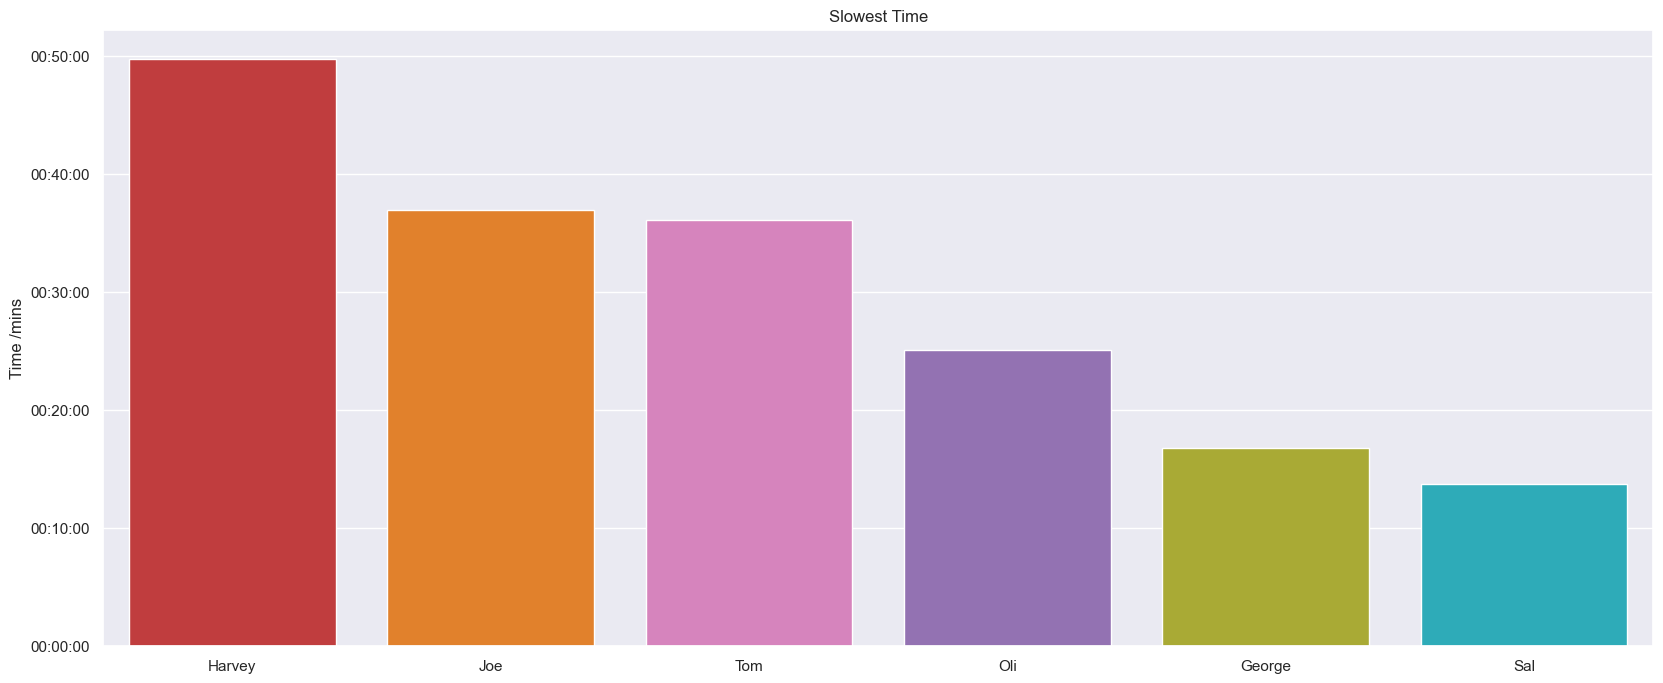

In [80]:
"""Barplot showing the longest completion time for each person """

fig, ax = plt.subplots(figsize=figsize)

plot = sns.barplot(data=df_overall_max_time,
                   x="user",
                   y="time_delta_as_num",
                   palette=palette).set(
    title='Slowest Time',
    ylabel='Time /mins',
    xlabel=None)

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

plt.show()

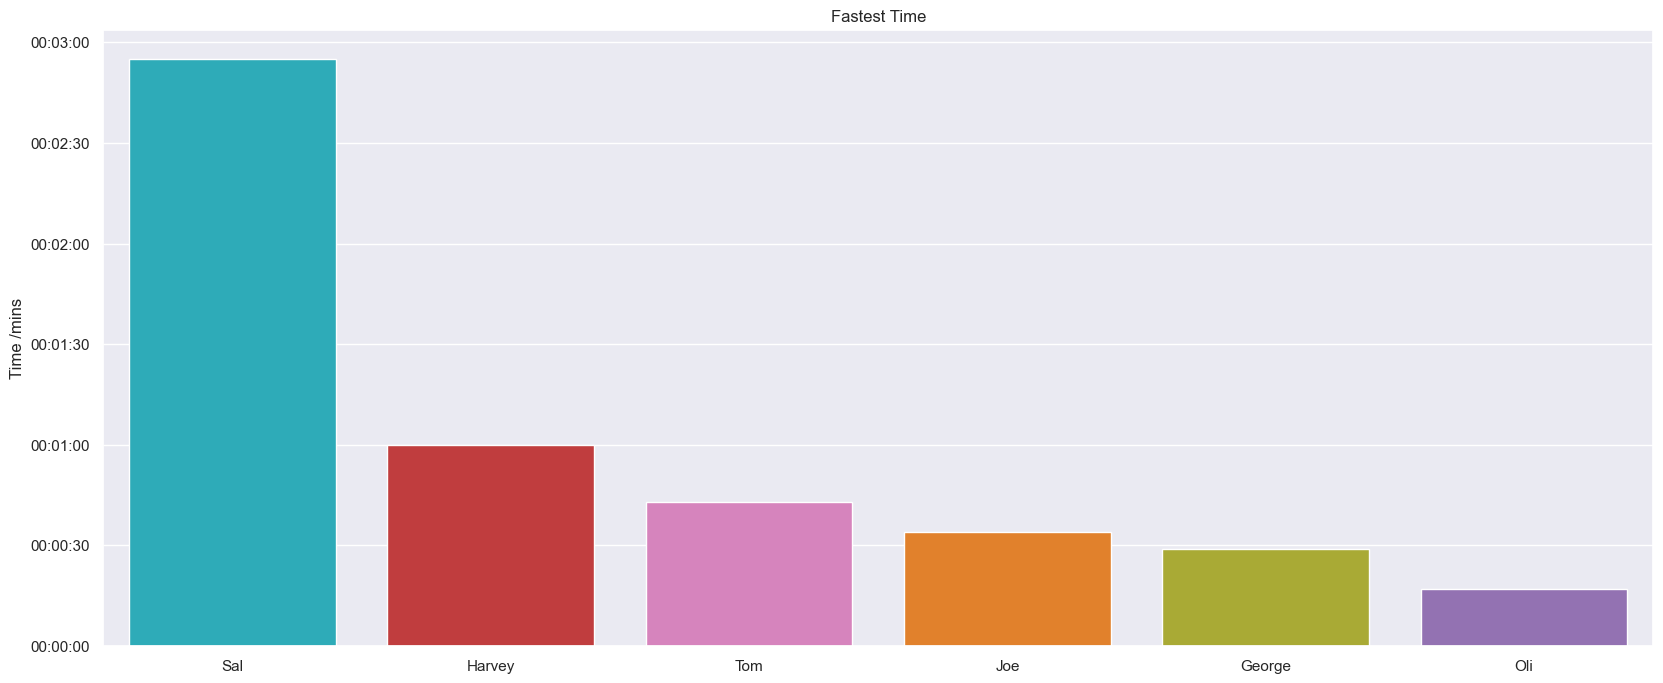

In [81]:
"""Barplot showing the shortest completion time for each person """

fig, ax = plt.subplots(figsize=figsize)

plot = sns.barplot(data=df_overall_min_time,
                   x="user",
                   y="time_delta_as_num",
                   palette=palette).set(
    title='Fastest Time',
    ylabel='Time /mins',
    xlabel=None)

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

plt.show()

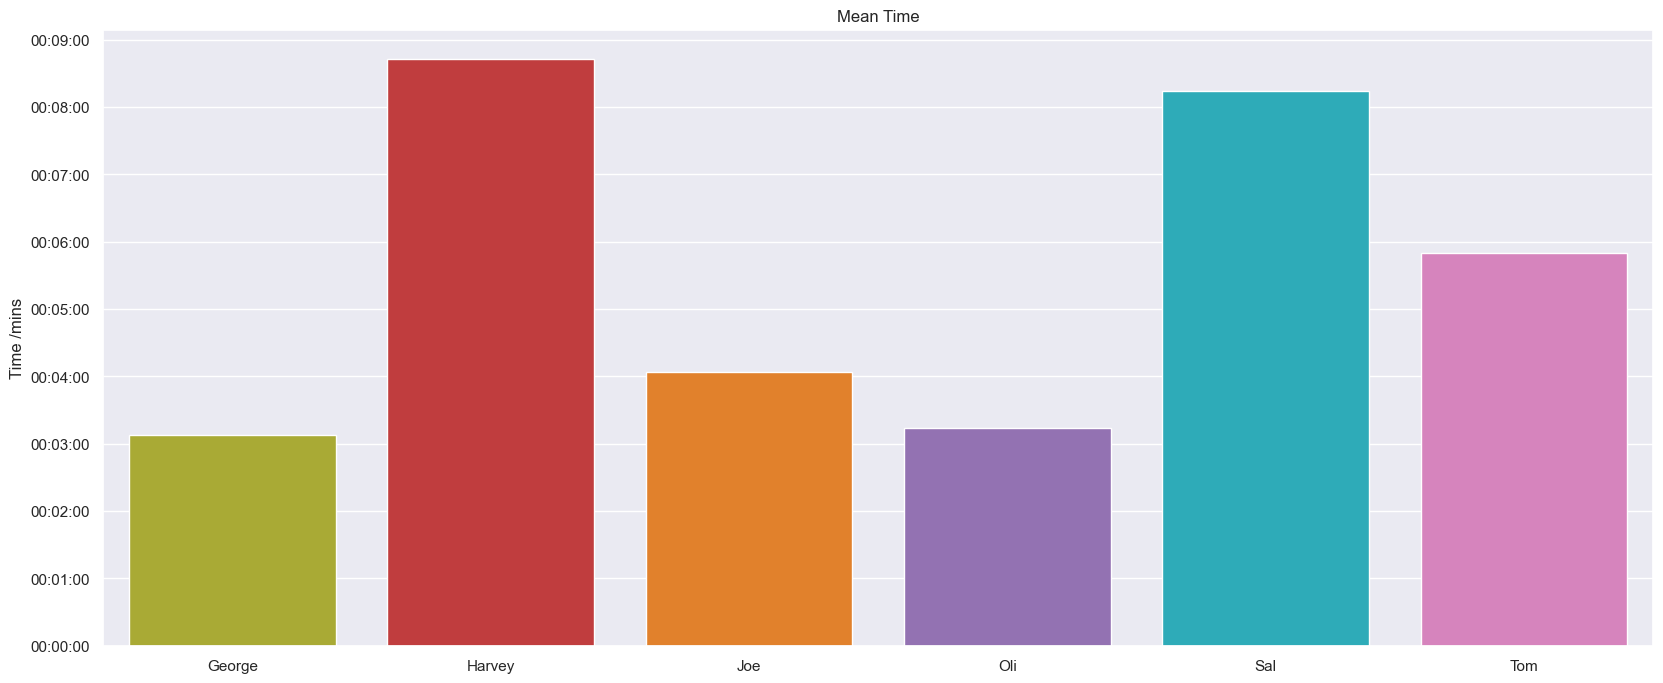

In [82]:
"""Barplot showing mean completion time for each person """

fig, ax = plt.subplots(figsize=figsize)

plot = sns.barplot(data=df_overall_mean_time,
                   x="user",
                   y="time_delta_as_num",
                   palette=palette).set(
    title='Mean Time',
    ylabel='Time /mins',
    xlabel=None)

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

plt.show()

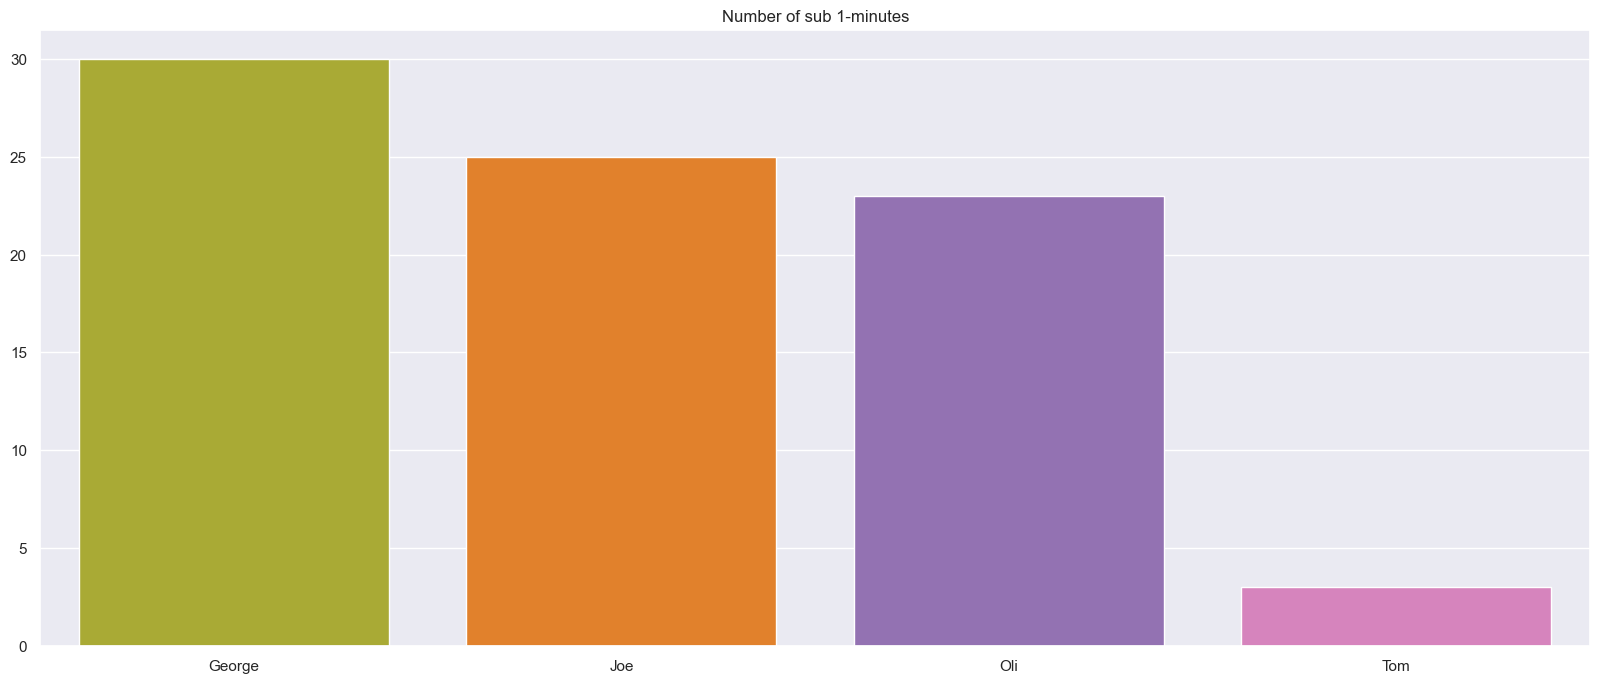

In [83]:
""" Barplot of how many sub 1-minute completion times for each person"""

fig, ax = plt.subplots(figsize=figsize)

plot = sns.barplot(data=df_sub_minnies,
                   y='count',
                   x='user',
                   palette=palette).set(
    title='Number of sub 1-minutes',
    ylabel=None,
    xlabel=None)

plt.xticks(rotation=0)

plt.show()


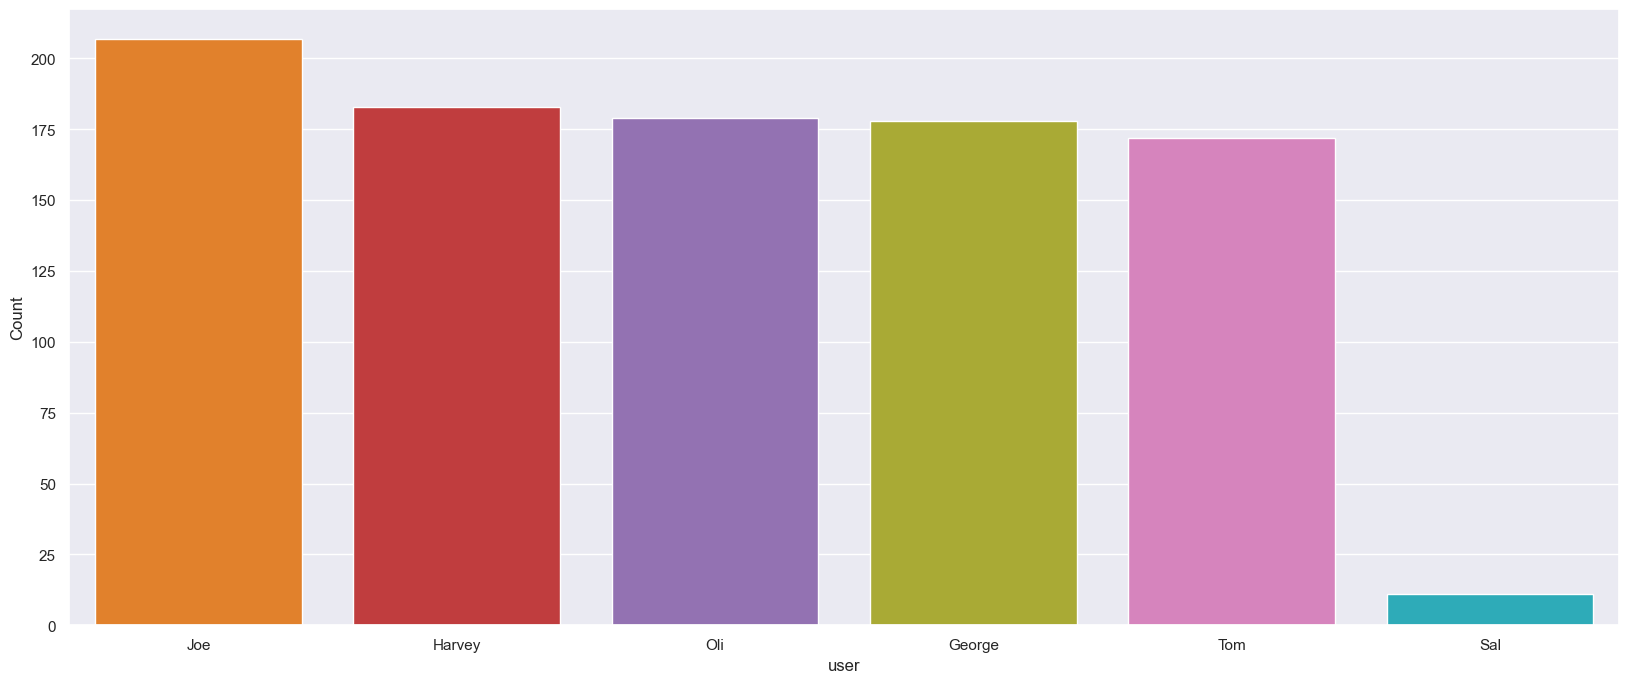

In [84]:
""" Barplot of how many submissions total for each person"""

fig, ax = plt.subplots(figsize=figsize)

plot = sns.barplot(data=df_overall_number_submissions,
                   y='Count',
                   x='user',
                   palette=palette)

plt.xticks(rotation=0)

plt.show()

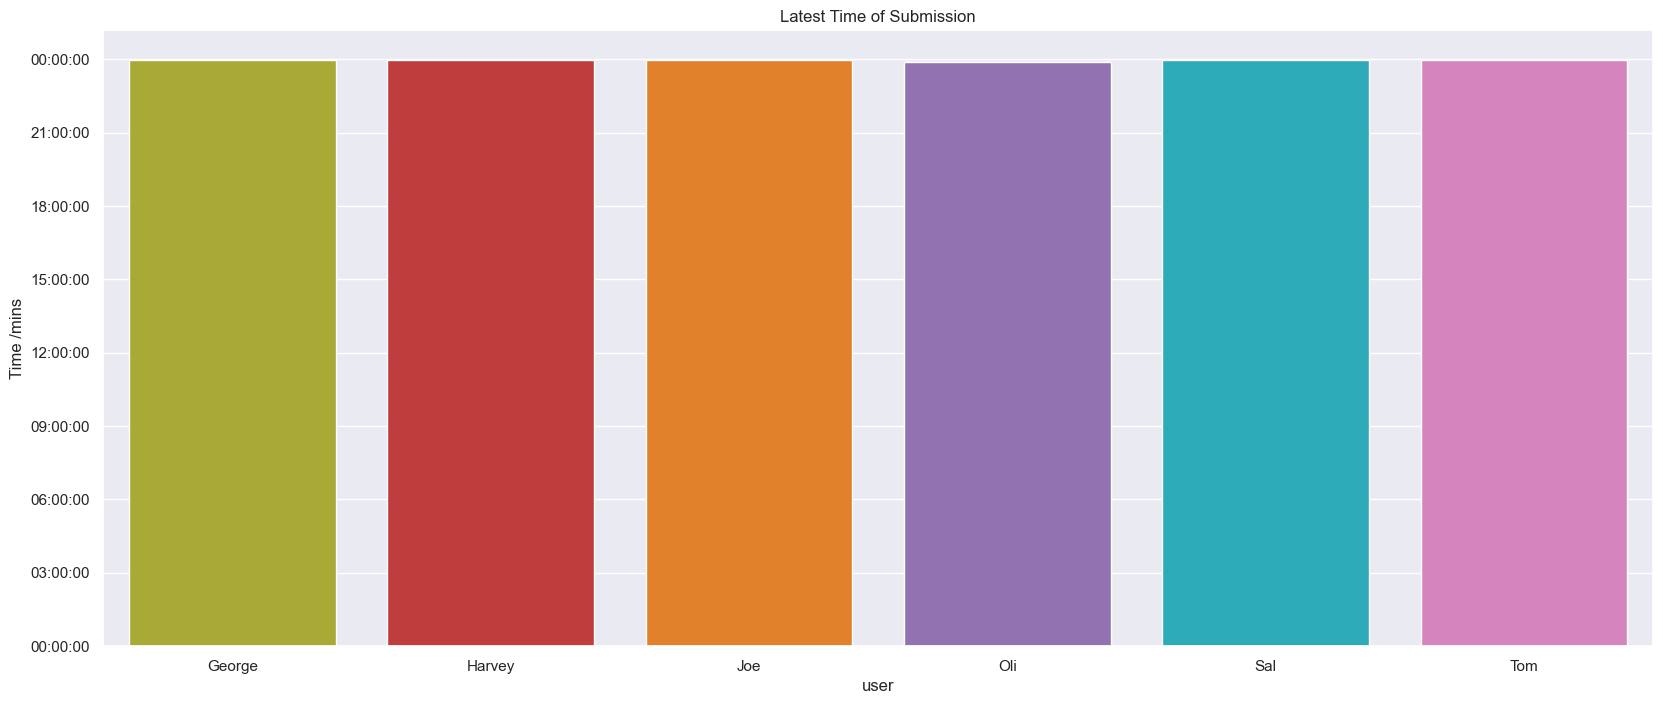

In [85]:
""" Barplot of the latest submission times for each person. Probably not worth plotting"""

fig, ax = plt.subplots(figsize=figsize)

plot = sns.barplot(data=df_latest_sub_time,
                   x='user',
                   y='sub_time_delta_as_num',
                   palette=palette).set(
    title='Latest Time of Submission',
    ylabel='Time /mins',
    label=None)

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

plt.show()

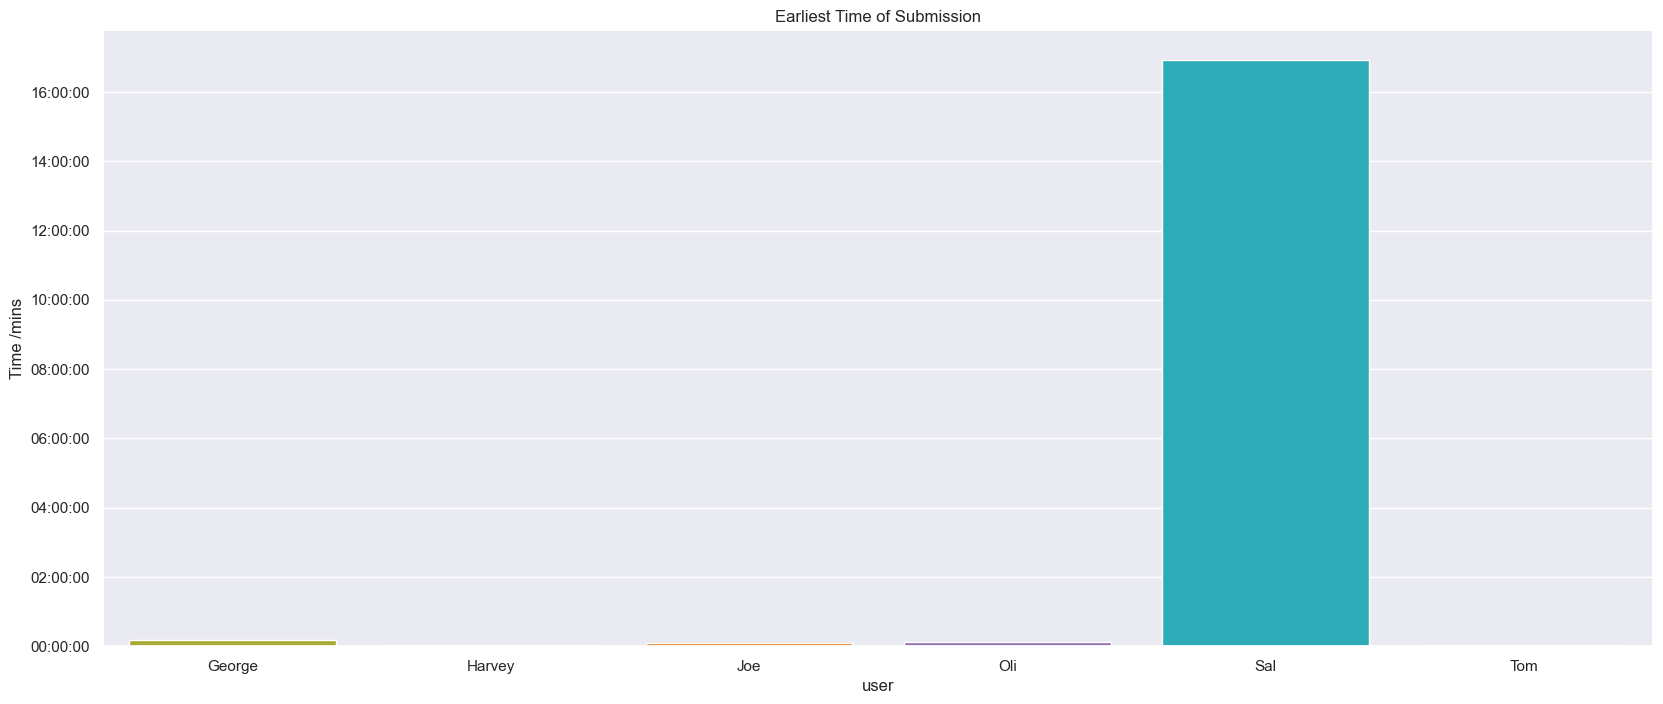

In [86]:
""" Barplot of the earliest submission times for each person. Probably not worth plotting"""

fig, ax = plt.subplots(figsize=figsize)

plot = sns.barplot(data=df_earliest_sub_time,
                   x='user',
                   y='sub_time_delta_as_num',
                   palette=palette).set(
    title='Earliest Time of Submission',
    ylabel='Time /mins',
    label=None)

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

plt.show()

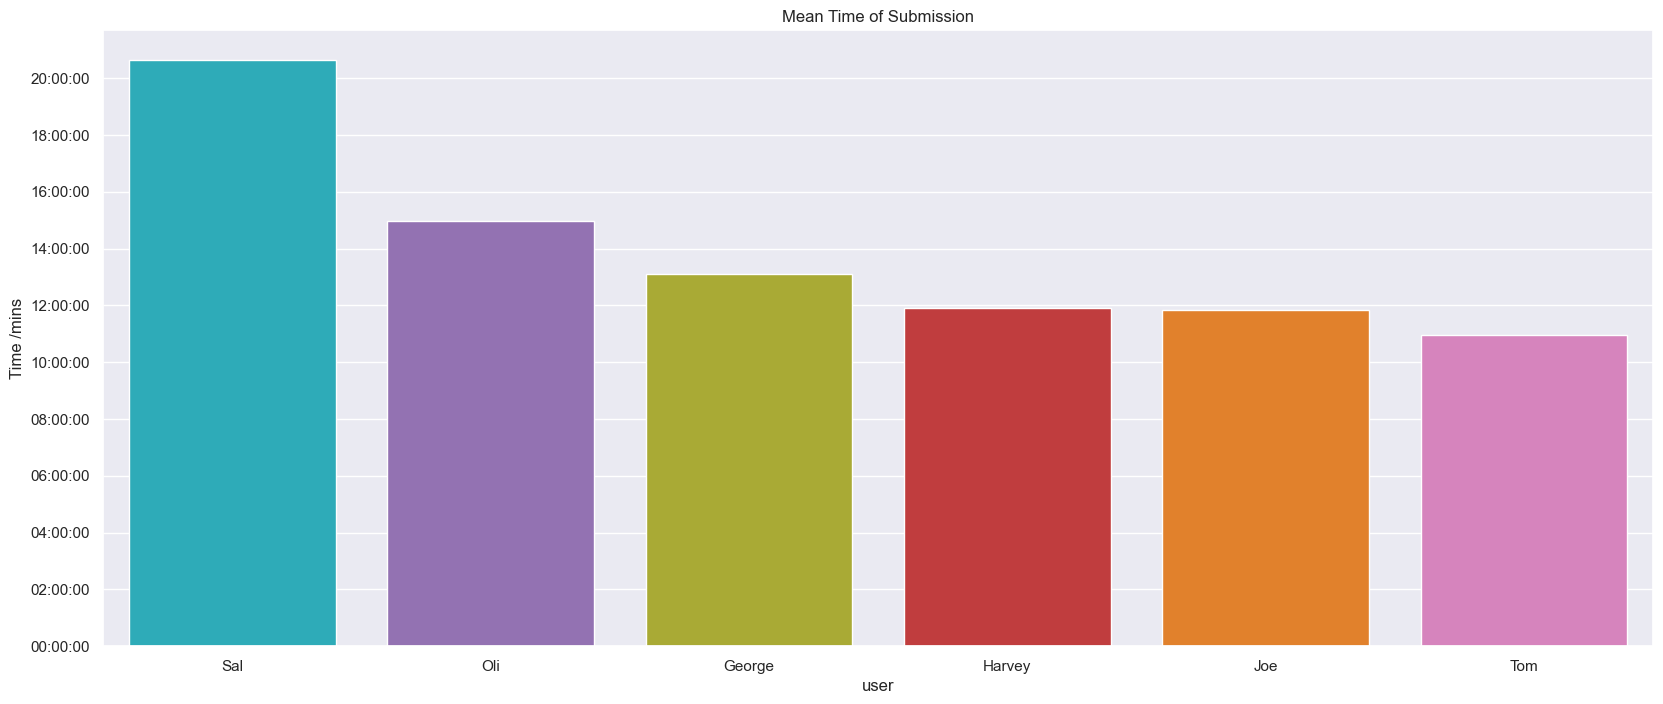

In [87]:
""" Barplot of mean submission times for each person """

fig, ax = plt.subplots(figsize=figsize)

plot = sns.barplot(data=df_mean_sub_time,
                   x='user',
                   y='sub_time_delta_as_num',
                   palette=palette).set(
    title='Mean Time of Submission',
    ylabel='Time /mins',
    label=None)

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

plt.show()

In [88]:
monthly_mean_dropdown = widgets.Dropdown(
    options=['George', 'Oli', 'Tom', 'Sal', 'Joe', 'Harvey'],
    value='George',
    description='User:',
    disabled=False,
)
display(monthly_mean_dropdown)

Dropdown(description='User:', options=('George', 'Oli', 'Tom', 'Sal', 'Joe', 'Harvey'), value='George')

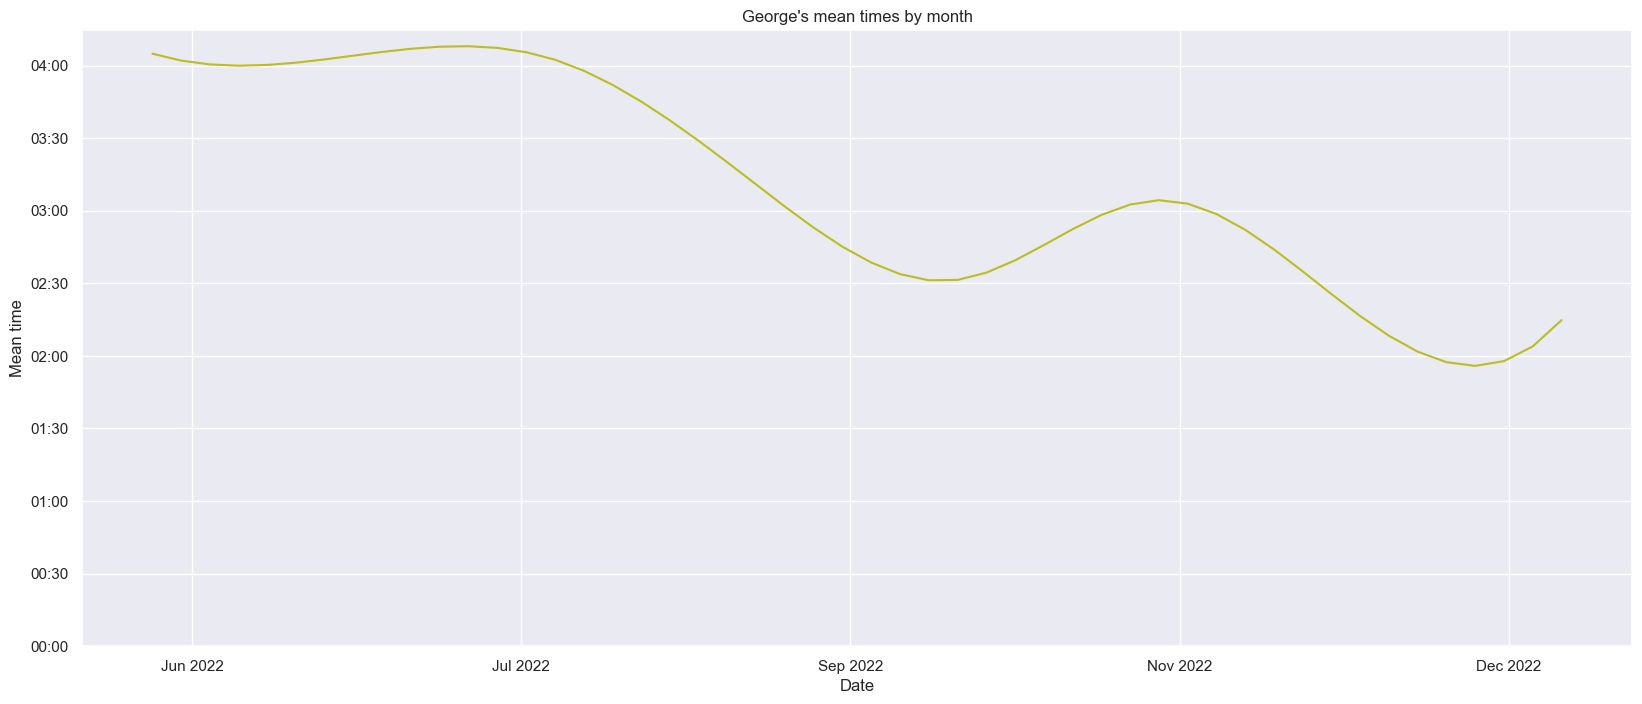

In [89]:

"""Filters out monthly mean time based on value of user. Then plots monthly mean times over time"""

user=monthly_mean_dropdown.value



fig, ax = plt.subplots(figsize=figsize)

x_smooth, y_smooth = spline_smooth(df_monthly_mean_time_user)

# plt.plot(x_smooth, y_smooth)

plot = sns.lineplot(x=x_smooth,
                    y=y_smooth,
                    color=palette[user]).set(
    title=user + '\'s mean times by month',
    ylabel='Mean time',
    xlabel='Date')

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

ax.set_ylim(ymin=0)

plt.show()

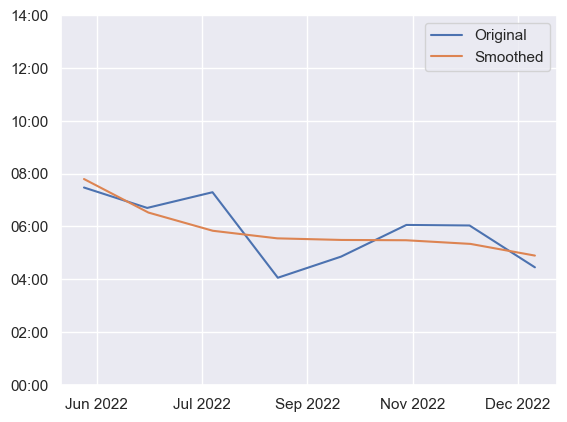

In [98]:
df_monthly_mean_time_user = df_monthly_mean_time[df_monthly_mean_time['user'] == user]

df_spline=df_monthly_mean_time_user.copy()

df_spline['date_as_num'] = mdates.date2num(df_spline['timestamp'])


# Smooth the data using a spline
x = df_spline['date_as_num']
y = df_spline['time_delta_as_num']
spline = interpolate.UnivariateSpline(x, y)
x_smooth = np.linspace(x.min(), x.max(), num=len(x))
y_smooth = spline(x_smooth)

# Plot the original and smoothed data
fig, ax = plt.subplots()
ax.plot(x, y, label='Original')
ax.plot(x_smooth, y_smooth, label='Smoothed')
ax.legend()

ax.yaxis_date()

ax.set_yticks(y_axis_time_2_mins)

ax.set_yticklabels(y_axis_time_2_mins)

ax.yaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# Show the plot
plt.show()

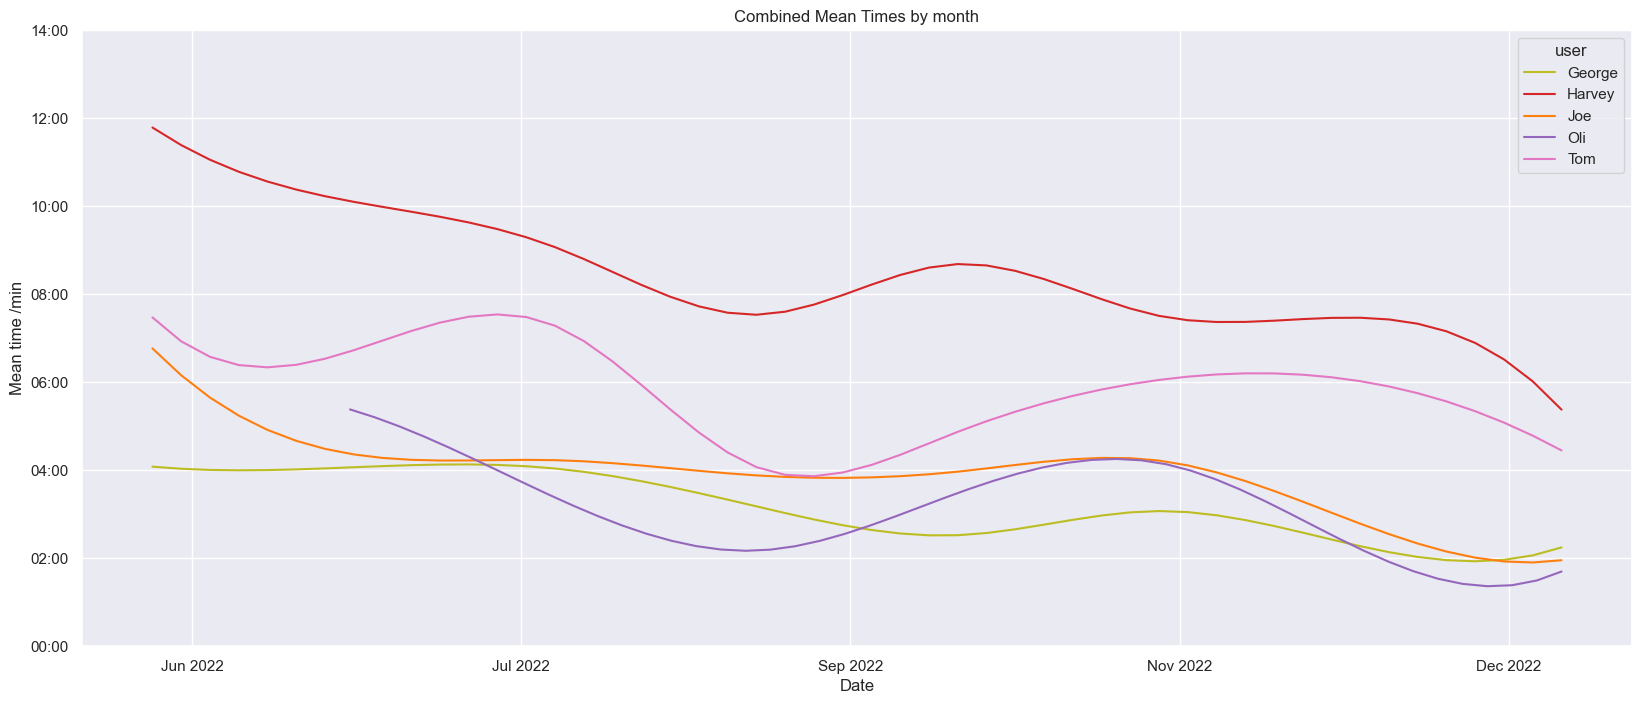

In [91]:

"""Plots monthly mean times for every player over time on the same lineplot"""

# Generates 15 minutes for y axis

y_axis_time = y_axis_generator(15, 'm')

# Selects every 2 minutes

y_axis_time_2_mins = y_axis_time[::2]

# Plot

fig, ax = plt.subplots(figsize=figsize)

# Smoothing function doesn't like that Sal only has a month of data so has to be removed

df_monthly_mean_time = df_monthly_mean_time[df_monthly_mean_time['user'] != 'Sal']

# Smooths lines out for each user and plots them

df_smooth = pd.DataFrame()

for user in df_monthly_mean_time['user'].unique():
    df_monthly_mean_time_rough = df_monthly_mean_time[df_monthly_mean_time['user'] == user]

    x_smooth, y_smooth = spline_smooth(df_monthly_mean_time_rough)

    # converts x_smooth, y_smooth into a dataframe with user value associated with them

    user_list = [user] * len(x_smooth)

    x_smooth = pd.Series(x_smooth, name='date_as_num_smooth')

    y_smooth = pd.Series(y_smooth, name='time_as_num_smooth')

    users = pd.Series(user_list, name='user')

    df = pd.concat([users, x_smooth, y_smooth], axis=1)

    # Joins dfs together to make one big one

    df_smooth = pd.concat([df_smooth, df])

plot = sns.lineplot(data=df_smooth,
                    x='date_as_num_smooth',
                    y='time_as_num_smooth',
                    hue='user',
                    palette=palette).set(
    title='Combined Mean Times by month',
    xlabel='Date',
    ylabel='Mean time /min')

ax.yaxis_date()

ax.set_yticks(y_axis_time_2_mins)

ax.set_yticklabels(y_axis_time_2_mins)

ax.yaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.show()

In [92]:
weekly_mean_dropdown = widgets.Dropdown(
    options=['George', 'Oli', 'Tom', 'Sal', 'Joe', 'Harvey'],
    value='George',
    description='User:',
    disabled=False,
)
display(weekly_mean_dropdown)

Dropdown(description='User:', options=('George', 'Oli', 'Tom', 'Sal', 'Joe', 'Harvey'), value='George')

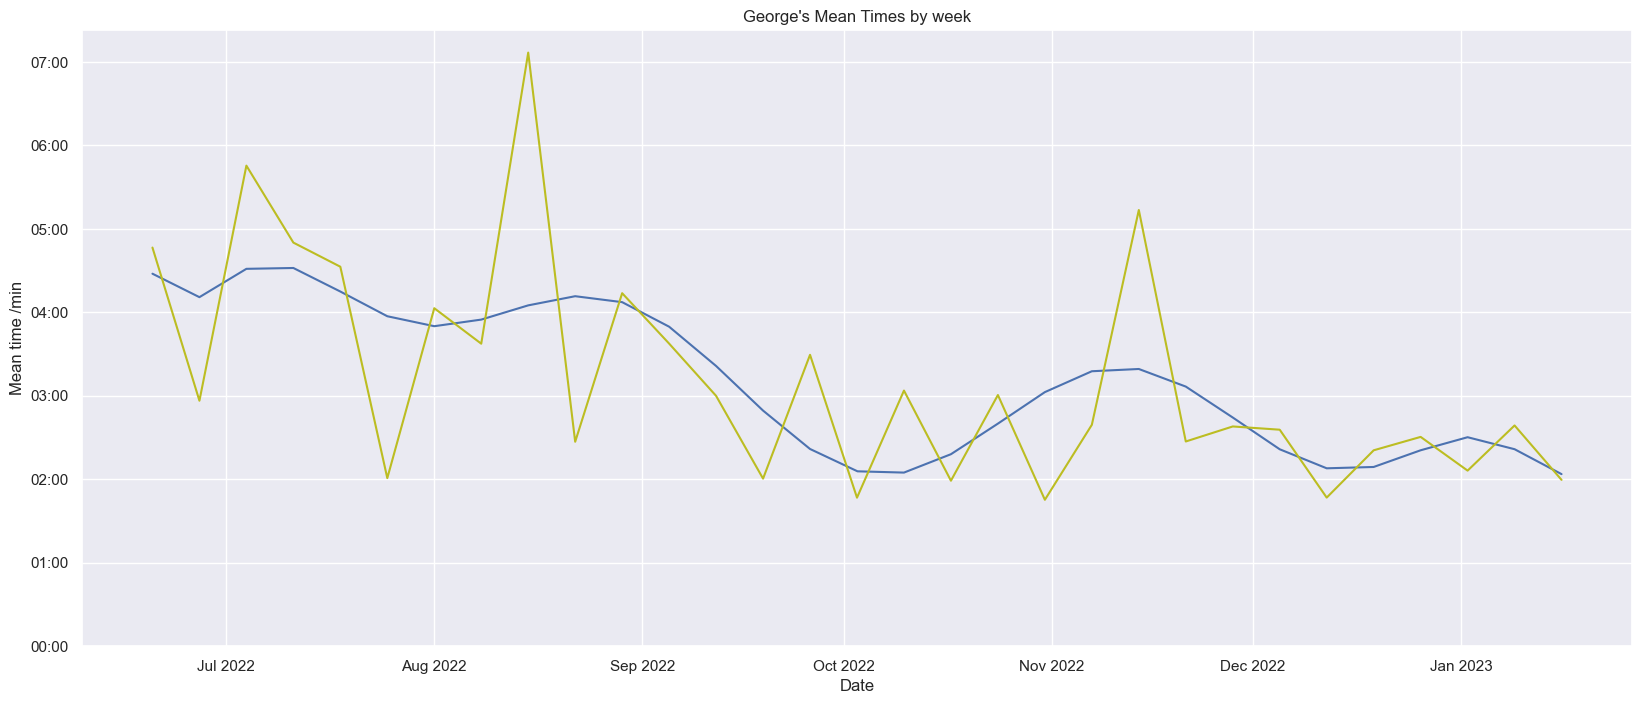

In [93]:
"""Filters out weekly mean time based on value of user. Then plots weekly mean times over time"""

user=weekly_mean_dropdown.value

df_weekly_mean_time_user = df_weekly_mean_time[df_weekly_mean_time['user'] == user]

fig, ax = plt.subplots(figsize=figsize)

x_smooth, y_smooth = savgol_smooth(df_weekly_mean_time_user)

plt.plot(x_smooth, y_smooth)

plot = sns.lineplot(data=df_weekly_mean_time_user,
                    x='timestamp',
                    y='time_delta_as_num',
                    color=palette[user]).set(
    title=user + '\'s Mean Times by week',
    xlabel='Date',
    ylabel='Mean time /min')

ax.yaxis_date()

ax.set_ylim(ymin=0)

ax.yaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.show()

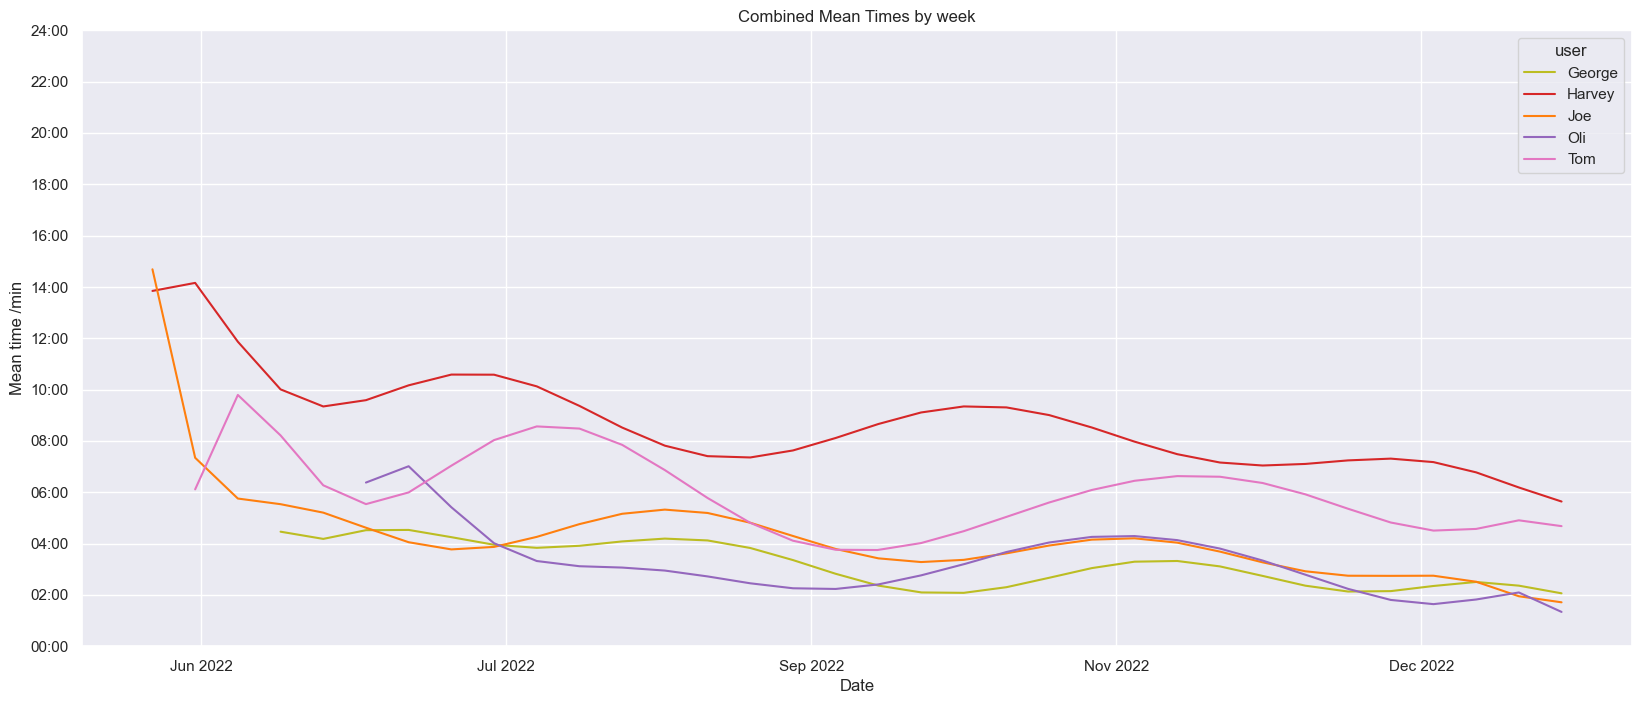

In [94]:
"""Plots weekly mean times for every player over time on the same lineplot"""

# Generates 25 mins for y-axis

y_axis_time = y_axis_generator(25, 'm')

# Displays every 2 mins

y_axis_time_num_2_mins = y_axis_time[::2]

fig, ax = plt.subplots(figsize=figsize)

# Smoothing function doesn't like that Sal only has a month of data so has to be removed

df_weekly_mean_time = df_weekly_mean_time[df_weekly_mean_time['user'] != 'Sal']

# Smooths lines out for each user and plots them

df_smooth = pd.DataFrame()

for user in df_weekly_mean_time['user'].unique():
    df_weekly_mean_time_rough = df_weekly_mean_time[df_weekly_mean_time['user'] == user]

    x_smooth, y_smooth = savgol_smooth(df_weekly_mean_time_rough)

    # converts x_smooth, y_smooth into a dataframe with user value associated with them

    user_list = [user] * len(x_smooth)

    x_smooth = pd.Series(x_smooth, name='date_as_num_smooth')

    y_smooth = pd.Series(y_smooth, name='time_as_num_smooth')

    users = pd.Series(user_list, name='user')

    df = pd.concat([users, x_smooth, y_smooth], axis=1)

    # Concats dfs together to make one big one

    df_smooth = pd.concat([df_smooth, df])

# Plotting

plot = sns.lineplot(data=df_smooth,
                    x='date_as_num_smooth',
                    y='time_as_num_smooth',
                    hue='user',
                    palette=palette).set(
    title='Combined Mean Times by week',
    xlabel='Date',
    ylabel='Mean time /min')

ax.yaxis_date()

ax.set_yticks(y_axis_time_num_2_mins)

ax.set_yticklabels(y_axis_time_num_2_mins)

ax.yaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.show()


(0, 0.006475308641347511)

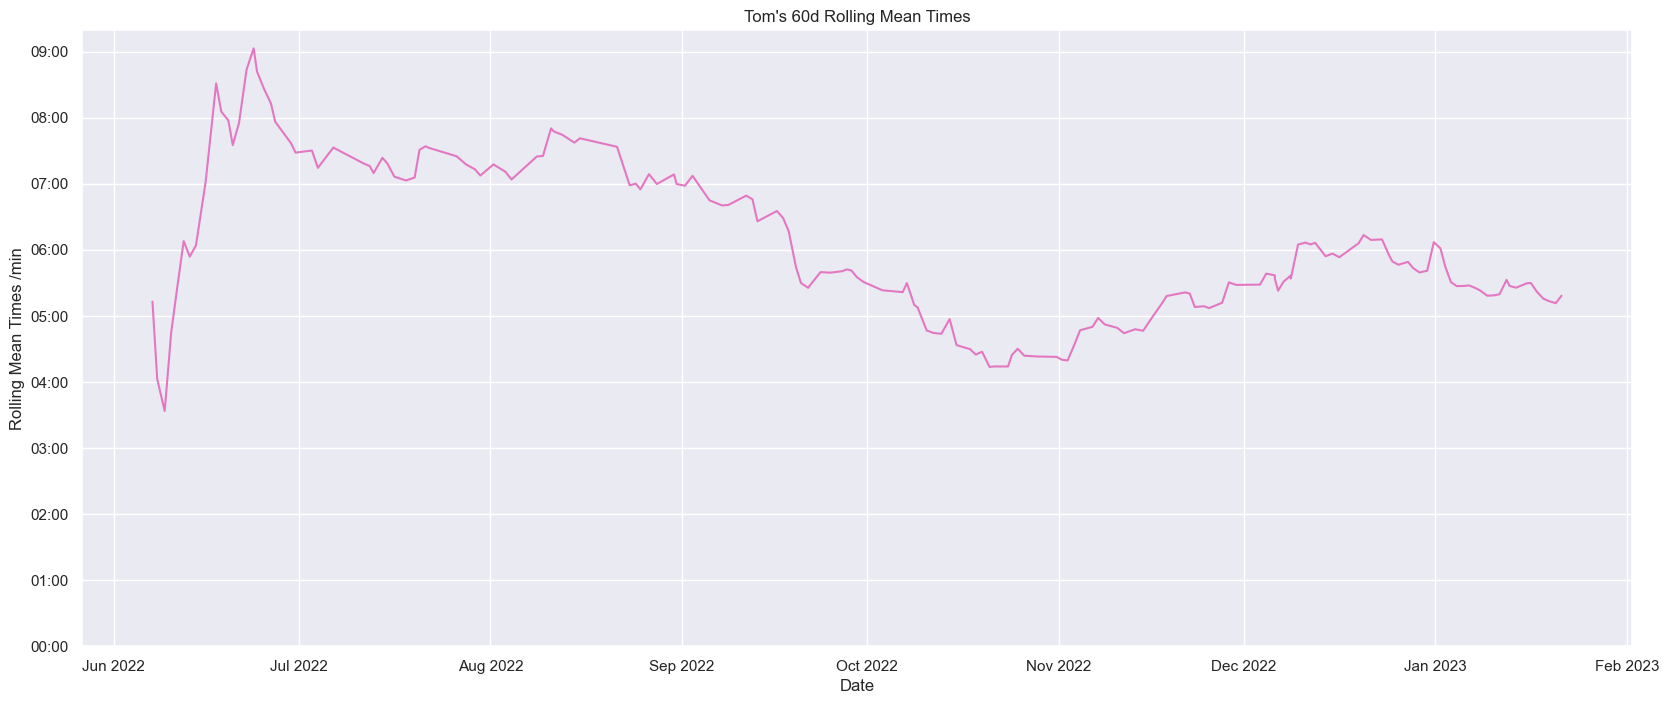

In [95]:
"""Filters out rolling average completion times based on value of user. Plots rolling average over time"""

df_ra_finished_user = df_ra_finished[df_ra_finished['user'] == user]

fig, ax = plt.subplots(figsize=figsize)

plot = sns.lineplot(data=df_ra_finished_user,
                    x='timestamp',
                    y='time_delta_as_num_RA',
                    color=palette[user]).set(
    title=user + '\'s ' + str(window_days) + 'd' + ' Rolling Mean Times',
    xlabel='Date',
    ylabel='Rolling Mean Times /min')

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

ax.set_ylim(ymin=0)

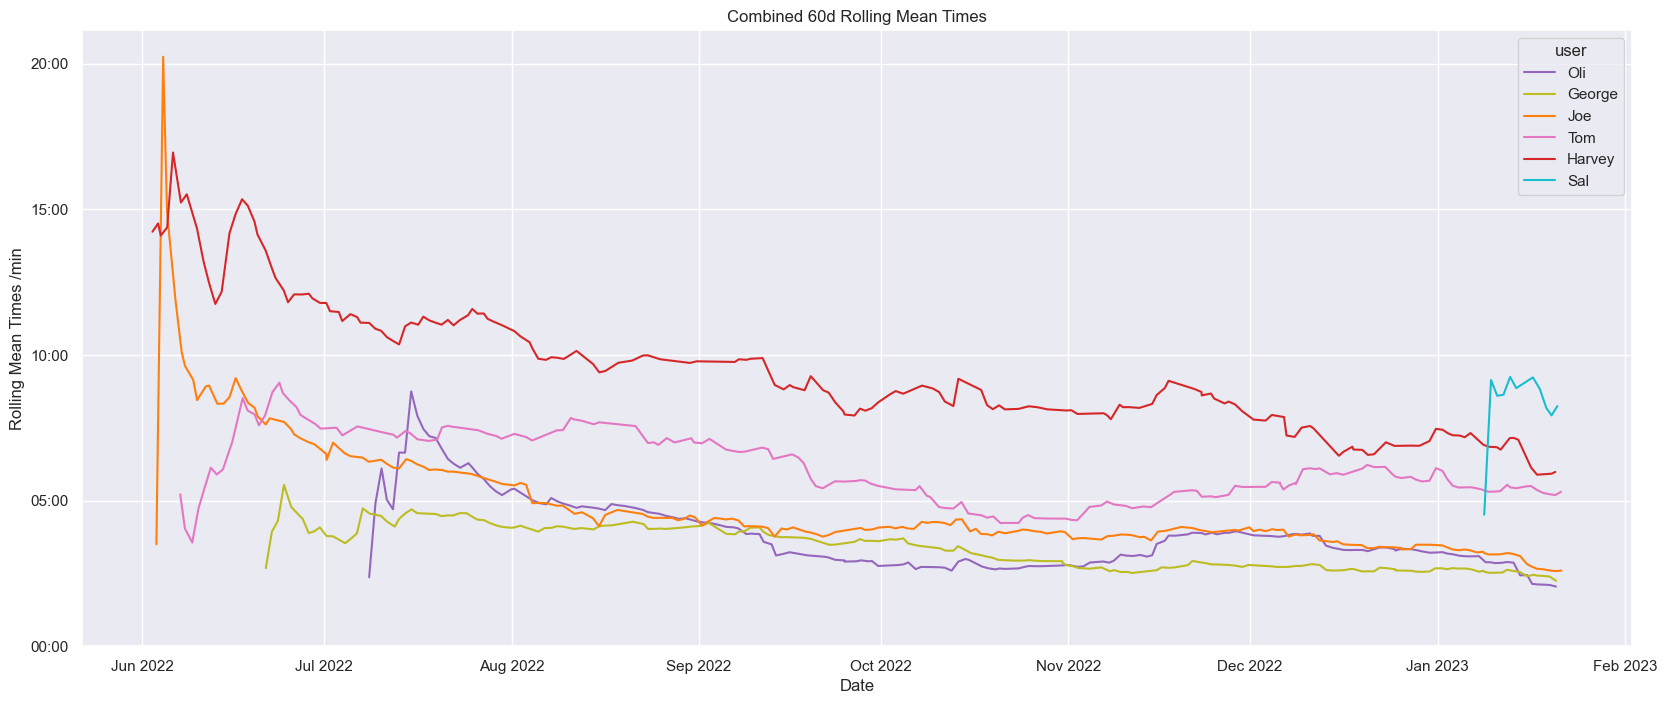

In [96]:
"""Plots rolling average over time for all players"""

fig, ax = plt.subplots(figsize=figsize)

plot = sns.lineplot(data=df_ra_finished,
                    x='timestamp',
                    y='time_delta_as_num_RA',
                    hue='user',
                    palette=palette).set(
    title='Combined ' + str(window_days) + 'd' + ' Rolling Mean Times',
    xlabel='Date',
    ylabel='Rolling Mean Times /min')

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

ax.set_ylim(ymin=0)

plt.show()

KeyError: 'sub_time_delta_as_num'

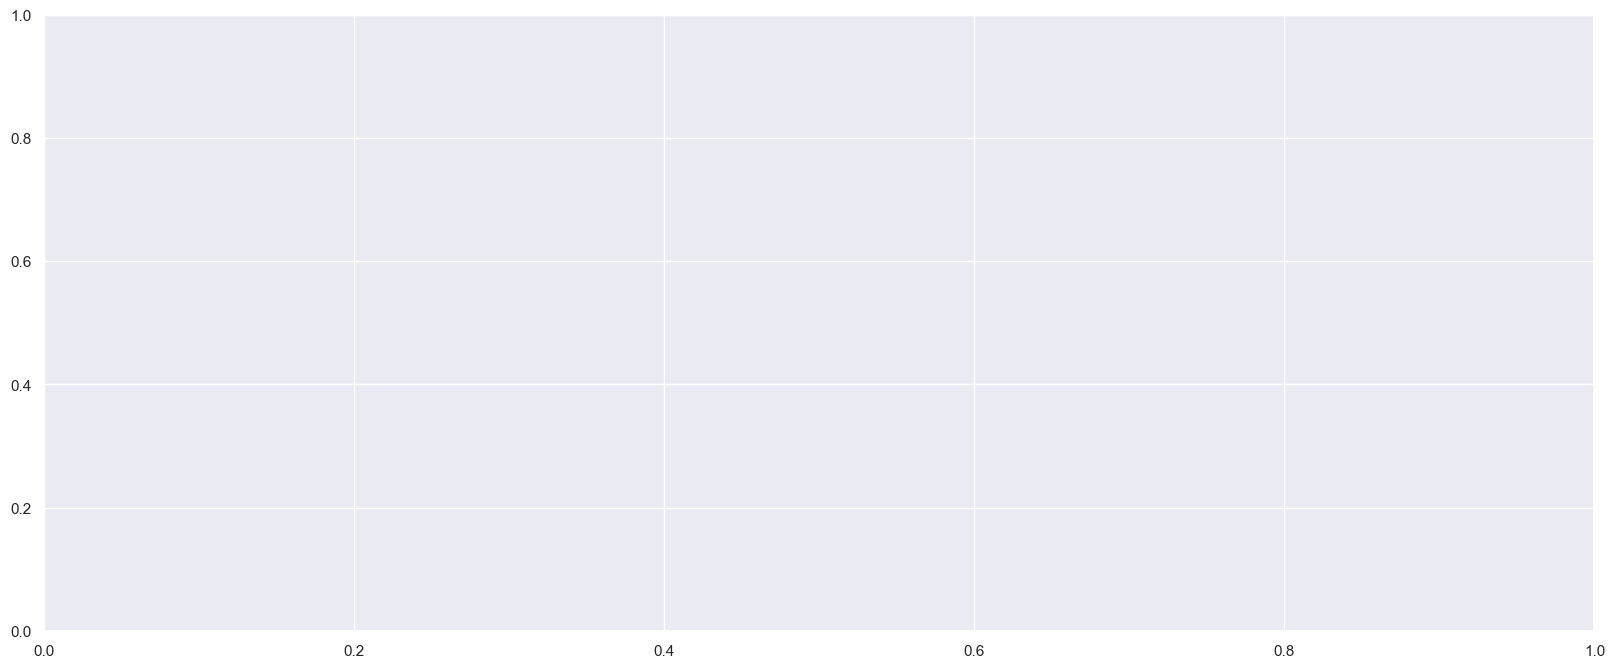

In [97]:
"""Plots boxplot of submission times"""

fig, ax = plt.subplots(figsize=figsize)

plot = sns.boxplot(data=df,
                   x="user",
                   y=df["sub_time_delta_as_num"],
                   palette=palette).set(
    ylabel='Time of Submission',
    xlabel=None)

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

ax.set_ylim(ymin=0)

plt.show()

In [ ]:
"""Plots violin plot of submission times"""

# Generates 24 hours for y axis

y_axis_time = y_axis_generator(24, 'h')

# selects every 2 hours

y_axis_time_2_hourly = y_axis_time[::2]

fig, ax = plt.subplots(figsize=figsize)

plot = sns.violinplot(data=df,
                      x="user",
                      y=df["sub_time_delta_as_num"],
                      cut=0,
                      bw=0.25,
                      palette=palette)

ax.yaxis_date()

ax.set_yticks(y_axis_time_2_hourly)

ax.set_yticklabels(y_axis_time_2_hourly)

ax.set_title('Time of Submission Violin Plot')

ax.set_xlabel(None)

ax.set_ylabel('Time of Submission')

ax.yaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

ax.set_ylim(ymin=0)

plt.show()

In [ ]:
"""Plots dist plot for submission times based on user"""

df_time_dist = df[df["user"] == user]

df_time_dist = df_time_dist.sort_values(by='sub_time_delta_as_num')

fig, ax = plt.subplots(figsize=figsize)

plt.xlim(0, 1)

plot = sns.displot(df_time_dist,
                   x=df_time_dist['sub_time_delta_as_num'],
                   bins=30,
                   stat='density',
                   kde=True,
                   color=palette[user]).set(
    title=user + '\'s Time of Submission distribution',
    xlabel='Time of Submission')

ax.xaxis_date()

ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

plot = sns.scatterplot(data=df,
                       x='date',
                       y='time_delta_as_num')

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

ax.set_title('20 Hardest Puzzles')

ax.set_xlabel(None)

ax.set_ylabel('Mean Time /mins')

ax.set_ylim(ymin=0)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

plot = sns.scatterplot(data=df,
                       x='date',
                       y='time_delta_as_num')

ax.yaxis_date()

ax.yaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

ax.set_title('20 easiest Puzzles')

ax.set_xlabel(None)

ax.set_ylabel('Mean Time /mins')

ax.set_ylim(ymin=0)

plt.show()

In [ ]:
def main():
    """Main script"""

    palette, figsize, user, window_days = settings()

    df = data_import()

    df = data_cleaning_and_prep(df)

    df_overall_max_time, df_overall_min_time, df_overall_mean_time = overall_times(df)

    df_overall_number_submissions = number_of_submissions(df)

    df_sub_minnies = number_of_sub_1_minnies(df)

    df_latest_sub_time, df_earliest_sub_time, df_mean_sub_time = submission_times(df)

    df_monthly_mean_time, df_monthly_max_time, df_monthly_min_time = monthly_times(df)

    df_weekly_mean_time, df_weekly_max_time, df_weekly_min_time = weekly_times(df)

    df_ra_finished, window_days = rolling_average(df, window_days)

    df_hardest = hardest_days(df)

    df_easiest = easiest_days(df)

    overall_max_time_barplot_fig = overall_max_time_barplot(df_overall_max_time, figsize, palette)

    overall_min_time_barplot_fig = overall_min_time_barplot(df_overall_min_time, figsize, palette)

    overall_mean_time_barplot_fig = overall_mean_time_barplot(df_overall_mean_time, figsize, palette)

    number_of_sub_1_minnies_barplot_fig = number_of_sub_1_minnies_barplot(df_sub_minnies, figsize, palette)

    number_of_submissions_barplot_fig = number_of_submissions_barplot(df_overall_number_submissions, figsize, palette)

    overall_sub_time_max_barplot_fig = overall_sub_time_max_barplot(df_latest_sub_time, figsize, palette)

    overall_sub_time_min_barplot_fig = overall_sub_time_min_barplot(df_earliest_sub_time, figsize, palette)

    overall_sub_time_mean_barplot_fig = overall_sub_time_mean_barplot(df_mean_sub_time, figsize, palette)

    individual_monthly_mean_lineplot_fig = individual_monthly_mean_lineplot(df_monthly_mean_time, figsize, palette,
                                                                            user)

    combined_monthly_mean_lineplot_fig = combined_monthly_mean_lineplot(df_monthly_mean_time, figsize, palette)

    individual_weekly_mean_lineplot_fig = individual_weekly_mean_lineplot(df_weekly_mean_time, figsize, palette, user)

    combined_weekly_mean_lineplot_fig = combined_weekly_mean_lineplot(df_weekly_mean_time, figsize, palette)

    individual_rolling_average_lineplot_fig = individual_rolling_average_lineplot(df_ra_finished, figsize, palette,
                                                                                  user, window_days)

    combined_rolling_average_lineplot_fig = combined_rolling_average_lineplot(df_ra_finished, figsize, palette,
                                                                              window_days)

    sub_time_boxplot_fig = sub_time_boxplot(df, figsize, palette)

    sub_time_violin_plot_fig = sub_time_violin_plot(df, figsize, palette)

    sub_time_distplot_fig = sub_time_distplot(df, figsize, palette, user)

    hardest_times_scatterplot_fig = hardest_times_scatterplot(df_hardest, figsize)

    easiest_times_scatterplot_fig = easiest_times_scatterplot(df_easiest, figsize)

In [ ]:
main()